In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from zfa.core.default_dirs import DATA_ROOT

from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget

%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
torch.cuda.is_available()

True

In [2]:
DATA_ROOT

from sklearn.preprocessing import MinMaxScaler

def normalize_series(series):
    # Ensure the series is in the correct shape for the MinMaxScaler (samples, features)
    reshaped_series = np.array(series).reshape(-1, 1)
    
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    normalized = scaler.fit_transform(reshaped_series)
    
    # Since our time series is a 1-D array, we can flatten the output to get it back into the original shape
    return normalized.flatten()

In [6]:
# has both neurons and glia

sesh1 = '/om2/group/fiete/zfa/000350/sub-20161109-2/sub-20161109-2_ses-20161109T211950_ophys.nwb'
sesh2 = '/om2/group/fiete/zfa/000350/sub-20170203-1/sub-20170203-1_ses-20170203T122038_ophys.nwb'
sesh3 = '/om2/group/fiete/zfa/000350/sub-20170228-3/sub-20170228-3_ses-20170228T165730_ophys.nwb'
sesh4 = '/om2/group/fiete/zfa/000350/sub-20170228-4/sub-20170228-4_ses-20170228T185002_ophys.nwb'



In [42]:
io = NWBHDF5IO(sesh3, mode="r", load_namespaces=True)
nwbfile = io.read()

trial_types = nwbfile.trials['trial_type']

/om2/user/leokoz8/envs/zfa/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/om2/user/leokoz8/envs/zfa/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/om2/user/leokoz8/envs/zfa/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [64]:
def get_neural_and_glial_trials(nwbfilepath):

    print('Reading file path...')
    io = NWBHDF5IO(nwbfilepath, mode="r", load_namespaces=True)
    nwbfile = io.read()
    
    print('Getting trial start and stop points...')
    glial_trace = nwbfile.processing['ophys']['DfOverF']['GliaDfOverF'].data
    neural_trace = nwbfile.processing['ophys']['DfOverF']['NeuronDfOverF'].data
    glial_times = np.asarray(nwbfile.processing['ophys']['DfOverF']['GliaDfOverF'].timestamps)

    behavior_state_types = nwbfile.processing['behavior']['ActivityStates']['state_type']
    behavior_start_times = nwbfile.processing['behavior']['ActivityStates']['start_time']
    behavior_stop_times = nwbfile.processing['behavior']['ActivityStates']['stop_time']

    trial_types = nwbfile.trials['trial_type']
    trial_start_times = np.asarray(nwbfile.trials['start_time'])
    trial_stop_times = np.asarray(nwbfile.trials['stop_time'])

    window_size = 10


    print('Extracting glial and neural trials...')
    glial_trials = []
    neural_trials = []
    for i,behavior in enumerate(behavior_state_types):
        if behavior == 'passive':
            start_ind = np.argmin(np.abs(glial_times- behavior_start_times[i]))
            #end_ind = np.argmin(np.abs(glial_times- behavior_stop_times[i]))
            glial_trial  = glial_trace[start_ind-window_size:start_ind + window_size,:]
            neural_trial = neural_trace[start_ind-window_size:start_ind + window_size,:]

            assert len(glial_trial) == len(neural_trial), print('Glial time series and neural time series not the same length!')

            glial_trials.append(glial_trial)
            neural_trials.append(neural_trial)
    return glial_trials, neural_trials


In [67]:
glial_trials_3,neural_trials_3 = get_neural_and_glial_trials(sesh3)
glial_trials_4,neural_trials_4 = get_neural_and_glial_trials(sesh4)


Reading file path...


/om2/user/leokoz8/envs/zfa/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/om2/user/leokoz8/envs/zfa/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/om2/user/leokoz8/envs/zfa/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Getting trial start and stop points...
Extracting glial and neural trials...
Reading file path...
Getting trial start and stop points...
Extracting glial and neural trials...


In [74]:
neural_trial_dict = {'filenames': [sesh3,sesh4], 'tensors': [neural_trials_3,neural_trials_4]}
glial_trial_dict = {'filenames': [sesh3,sesh4], 'tensors': [glial_trials_3,glial_trials_4]}

In [78]:
neural_trial_dict['filenames']

['/om2/group/fiete/zfa/000350/sub-20170228-3/sub-20170228-3_ses-20170228T165730_ophys.nwb',
 '/om2/group/fiete/zfa/000350/sub-20170228-4/sub-20170228-4_ses-20170228T185002_ophys.nwb']

In [75]:
np.save('/om2/group/yanglab/zfa/glial_trials.npy',np.asanyarray(neural_trial_dict,dtype=object))
np.save('/om2/group/yanglab/zfa/neural_trials.npy',np.asanyarray(glial_trial_dict,dtype=object))

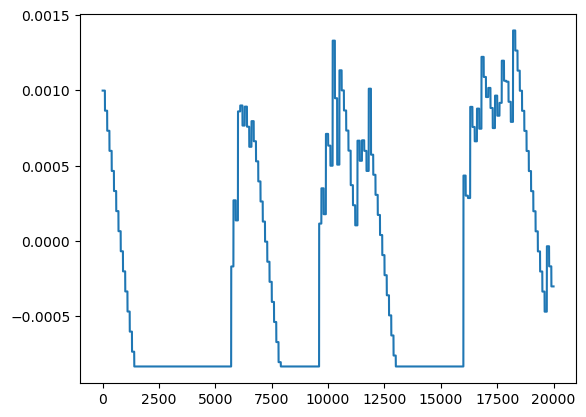

In [55]:
plt.plot(nwbfile.acquisition['TotalStimulusVelocitySignal'].data[:20000])

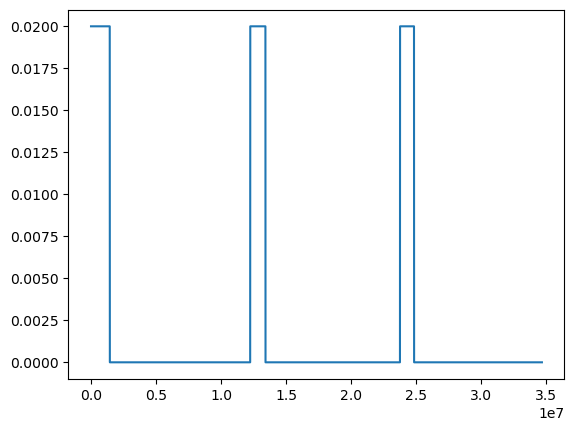

In [41]:
plt.plot(nwbfile.acquisition['StimulusGainSignal'].data[:])

In [6]:
offset = 10
avg_glial_traces = 0
avg_neural_traces = 0

len_state_types = len(state_types)
number_glia_timepoints = len(glial_times)

for t,state in enumerate(state_types):
    if state == 'active':
        passive_start_time = start_times[t]
        
        passive_start_ind = np.argmin(np.abs(glial_times-passive_start_time))
        
        print(passive_start_ind)
        if (passive_start_ind > offset) & (passive_start_ind + offset < number_glia_timepoints):
            passive_glial_trace = np.mean(glial_trace[passive_start_ind-offset:passive_start_ind+offset,:],axis = 1)
            passive_neural_trace = np.mean(neural_trace[passive_start_ind-offset:passive_start_ind+offset,:],axis = 1)
        
            avg_glial_traces += passive_glial_trace
            avg_neural_traces += passive_neural_trace

404
464
466
507
511
543
544
587
588
623
623
661
664
701
703
720
741
743
782
785
817
823
862
864
899
904
941
943
976
983
1024
1055
1065
1104
1143
1181
1219
1224
1262
1340
1381
1424
1462
1502
1544
1582
1660
1692
1702
1743
1982
1983
2209
2495
2531
2540
2573
2612
2621
2621
2660
2660
2696
2729
2740
2780
2780
2811
2820
2861
2861
2896
2900
2929
2940
2940
2973
2981
2981
3000
3008
3015
3020
3062
3062
3087
3100
3100
3141
3141
3171
3178
3180
3198
3198
3217
3561
3562
3592
3592
3622
3632
3632
3672
3672
3701
3752
3752
3777
3777
3790
3802
3802
3854
3854
3908
3908
3954
3954
4003
4003
4043
4052
4052
4103
4103
4131
4150
4151
4205
4205
4225
4255
4255
4281
4281
4298
4308
4308
4357
4357
4380
4380
4404
4404
4428
4454
4454
4501
4503
4552
4552
4604
4605
4628
4628
4654
4654
4676
4676
4698
4701
4721
4721
4743
4754
4754
4803
4804
4824
4824
4853
4853
4876
4876
4900
4953
4954
5002
5002
5055
5055
5110
5110
5153
5153
5195
5205
5205
5246
5251
5274
5274
5304
5304
5355
5355
5376
5376
5403
5403
5452
5453
5501
5501
5552


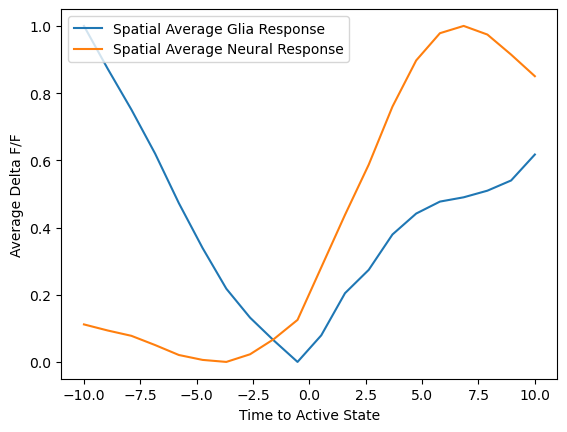

In [7]:
times_futile = np.linspace(-offset,offset,len(avg_glial_traces))

plt.plot(times_futile,normalize_series(avg_glial_traces),label = 'Spatial Average Glia Response')
plt.plot(times_futile,normalize_series(avg_neural_traces),label = 'Spatial Average Neural Response')
plt.ylabel('Average Delta F/F')
plt.xlabel('Time to Active State')
plt.legend()

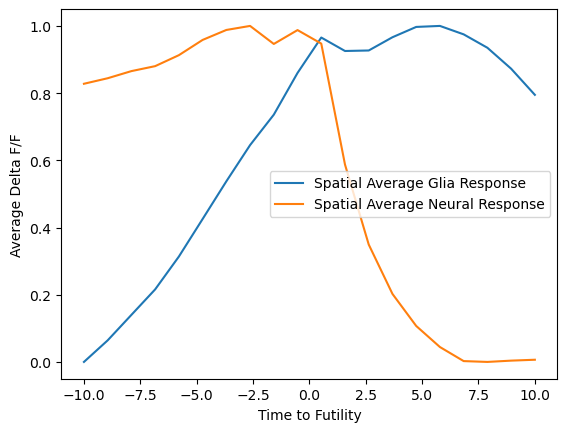

In [28]:
times_futile = np.linspace(-offset,offset,len(avg_glial_traces))

plt.plot(times_futile,normalize_series(avg_glial_traces),label = 'Spatial Average Glia Response')
plt.plot(times_futile,normalize_series(avg_neural_traces),label = 'Spatial Average Neural Response')
plt.ylabel('Average Delta F/F')
plt.xlabel('Time to Futility')
plt.legend()


In [ ]:

#neural_trace.shape



state_types[24]


        
        
avg_glial_traces /= len(state_types) 
avg_neural_traces /= len(state_types)

passive_start_time = start_times[24]
passive_start_ind = np.argmin(np.abs(glial_times-passive_start_time))

passive_glial_trace = np.mean(glial_trace[passive_start_ind-offset:passive_start_ind+offset,:],axis = 1)
passive_neural_trace = np.mean(neural_trace[passive_start_ind-offset:passive_start_ind+offset,:],axis = 1)






times_futile = np.linspace(-offset,offset,len(avg_glial_traces))


plt.plot(normalize_series(passive_glial_trace),label = 'Glial')
plt.plot(normalize_series(passive_neural_trace), label = 'Neural')
plt.legend()


from sklearn.preprocessing import MinMaxScaler
import numpy as np

plt.plot(times_futile,normalize_series(avg_glial_traces),label = 'Average Glia')
plt.plot(times_futile,normalize_series(avg_neural_traces),label = 'Average Neurons')
plt.ylabel('Average Delta F/F')
plt.xlabel('Time to Futility')
plt.legend()

453


TypeError: MultiContainerInterface.__make_getitem.<locals>._func: incorrect type for 'name' (got 'tuple', expected 'str')